# Appendix: Model Comparisons

- Polarity Reversal: Compare the polarity reversal between PFSS, MHD, and trajectory
- MHD v. In Situ: Compare the in situ measurements from Solar Orbiter and PSP to MHD produced observables sampled along the spacecraft's trajectories
- PFSS CH v. CHMAP CH: Compare CH produced from the PFSS solution to those modeled by EZSEG

# Appendix A: Modeling Comparisons

- Figure A.1: Comparison of polarity estimates with measurements
- Figure A.2: Comparison of MHD modeled observables with observations

In [1]:
import sys, os
import glob
import datetime
import numpy as np
sys.path.append(os.path.realpath(''))
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
import astrospice
import sunpy 
from astropy.coordinates import SkyCoord
import sunpy.coordinates as scoords

import tools.utilities as utils
# import tools.psp_funcs as psp_funcs
import tools.pfss_funcs as pfss_funcs

import mhd 
from psipy.model import MASOutput

from tools.utilities import rollto180
from scipy.interpolate import interp1d

from sunpy.map.header_helper import make_heliographic_header

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
for sc in ['psp','solar orbiter'] : kernels = astrospice.registry.get_kernels(sc,'predict') 

# REGIONS
loc_hcs = [59.5, 62]
loc_hcs1 = [357, 358.8]
ssw = [9, 19]
fsw = [42, 52]

# COLORS - 'azure'
cc = ['lightpink', 'mediumspringgreen', 'peachpuff', 'powderblue', 'thistle', 'palegoldenrod']
scol, hcol, fcol, rcol = ['lavender', 'azure', 'lavenderblush', 'grey']
# cc = ['black', 'red', 'blue', 'green']
clight = ['lightgrey', '#E6A8C9', '#E6A8C9', '#A8E6BF']

# DIRECTORIES
RES_DIR = os.path.join('/Users/tamarervin/', 'e15_results')
FIG_DIR = os.path.realpath('figures')
EPS_DIR = os.path.realpath('eps_figures')
PlotDir = '/Users/tamarervin/mplstyle/'

# PLOT STYLING
plot_style = os.path.join(PlotDir, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
plt.rcParams.update({'font.size': 20})
plt.style.use(plot_style)
plt.rcParams['axes.linewidth'] = 3


enc='E15'


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/tamarervin/miniconda3/envs/analysis/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

## Import Data

In [2]:
### READ IN DATA ###
parker, parkerdownt, parkerdownl, pss, orbiter, orbiterdownl, orbiterdownt, oss, wind, winddownt, winddownl, wss = utils.read_data(RES_DIR, sigma_time=20, pflag=True)

### DEFINE REGIONS ###
lon_footpoints = parker.sslon
hhcs = np.logical_and(lon_footpoints >= loc_hcs[0], lon_footpoints <=loc_hcs[1])
hhcs1 = np.logical_and(lon_footpoints >= loc_hcs1[0], lon_footpoints <=loc_hcs1[1])
slow = np.logical_and(lon_footpoints >=ssw[0], lon_footpoints <=ssw[1])
fast = np.logical_and(lon_footpoints >=fsw[0], lon_footpoints <=fsw[1])

/Users/tamarervin/publications/e15/tools/utilities.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parker['flag'][sa] = np.zeros(len(parker['flag'][sa]))
/Users/tamarervin/publications/e15/tools/utilities.py:172: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  pss = parker.resample(sigma_bin, closed='left', label='left', loffset=sigma_bin / 2).mean()
/Users/tamarervin/publications/e15/tools/utilities.py:172: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numer

## Potential Field Source Surface (PFSS) Model

### Create PFSS

In [3]:
# download/read in magnetogram
rss=2.5
local_path = os.path.join('/Volumes/TAMARUSB/pub_data', 'e15_adapt')
print(local_path)
files = sorted(glob.glob(os.path.join(local_path, '*.fts.gz')))
filepath = files[1]

# create magnetogram
adapt_magnetogram = pfss_funcs.adapt2pfsspy(filepath, return_magnetogram=True)
gong_map = sunpy.map.Map(adapt_magnetogram.data/1e5, adapt_magnetogram.meta)

# run PFSS model
pfss_model = pfss_funcs.adapt2pfsspy(filepath,rss)

# trace PFSS lines
flines = pfss_funcs.pfss2flines(pfss_model)

/Volumes/TAMARUSB/pub_data/e15_adapt
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,dsun_obs,crln_obs
 [sunpy.map.mapbase]
/Users/tamarervin/miniconda3/envs/analysis/lib/python3.11/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


### Coordinate Projection

In [4]:
def ballistically_project(skycoord,r_inner = 2.5*u.R_sun, vr_arr=None) :
    """
    Given a `SkyCoord` of a spacecraft trajectory in the Carrington frame,
    with `representation_type="spherical"`, and optionally an array of
    measured solar wind speeds at the same time intervals of the trajectory,
    return a SkyCoord for the trajectory ballistically projected down to 
    `r_inner` via a Parker spiral of the appropriate curvature. When `vr_arr`
    is not supplied, assumes wind speed is everywhere 360 km/s
    """
    if vr_arr is None : vr_arr = np.ones(len(skycoord))*360*u.km/u.s
    lons_shifted = skycoord.lon + ballistic_delta_long(skycoord.radius,
                                             r_inner=r_inner,
                                             vsw=vr_arr
                                            )
    return SkyCoord(
        lon = lons_shifted, 
        lat = skycoord.lat,
        radius = r_inner * np.ones(len(skycoord)),
        representation_type="spherical",
        frame = skycoord.frame
    )


@u.quantity_input
def ballistic_delta_long(r:u.R_sun,
               r_inner=2.5*u.R_sun,
               vsw=360.*u.km/u.s,
               omega_sun=14.713*u.deg/u.d,
               ):
    """ 
    Ballistic longitudinal shift of a Parker spiral connecting two
    points at radius r and r_inner, for a solar wind speed vsw. Solar
    rotation rate is also tunable
    """
    return (omega_sun * (r - r_inner) / vsw).to("deg")

In [5]:
### ------ PARKER SOLAR PROBE ------ ###
### Create SkyCoord for PSP in the inertial (J2000) frame
psp_inertial = astrospice.generate_coords(
    'SOLAR PROBE PLUS', parker.Time

)
### Transform to solar co-rotating frame 
psp_carrington = psp_inertial.transform_to(
    scoords.HeliographicCarrington(observer="self")
)

# projection
ts_common = np.array([dt.timestamp() for dt in parker.Time])
psp_vr_ts = [int(dt.timestamp()) for dt in parker.Time]
psp_vr_common = interp1d(psp_vr_ts,parker.vr,bounds_error=False)(ts_common)*u.km/u.s
psp_at_source_surface = ballistically_project(psp_carrington,vr_arr=psp_vr_common, r_inner=2.5*u.R_sun)
psp_projected = ballistically_project(psp_carrington,vr_arr=psp_vr_common, r_inner=19.5*u.R_sun)


## ------ SOLAR ORBITER ------ ###
### Create SkyCoord for PSP in the inertial (J2000) frame
tt = orbiter.Time
solo_inertial = astrospice.generate_coords(
    'SOLAR ORBITER', tt

)
### Transform to solar co-rotating frame 
solo_carrington = solo_inertial.transform_to(
    scoords.HeliographicCarrington(observer="self")
)

# projection
ts_common = np.array([dt.timestamp() for dt in tt])
solo_vr_ts = [int(dt.timestamp()) for dt in tt]
solo_vr_common = interp1d(solo_vr_ts,orbiter.vr,bounds_error=False)(ts_common)*u.km/u.s
solo_at_source_surface = ballistically_project(solo_carrington,vr_arr=solo_vr_common, r_inner=2.5*u.R_sun)
solo_projected = ballistically_project(solo_carrington,vr_arr=solo_vr_common, r_inner=19.5*u.R_sun)


### PFSS Solution

In [6]:
# get Br at the source surface from the pfss model
pfss_br = pfss_model.source_surface_br

# get HCS
hcs = pfss_model.source_surface_pils[0]

# get trajectory 
polarity = np.sign(parker.BrR2)
pos = np.where(polarity == 1)
neg = np.where(polarity == -1)

# get field lines
flines_psp = pfss_funcs.pfss2flines(pfss_model, skycoord_in=psp_at_source_surface)
# flines_solo = pfss_funcs.pfss2flines(pfss_model, skycoord_in=solo_at_source_surface)

# high res field lines
flines_highres = pfss_funcs.pfss2flines(pfss_model,nth=181,nph=361)

# get field line topology defined by polarity
topologies = flines_highres.polarities.reshape([181,361])

/Users/tamarervin/miniconda3/envs/analysis/lib/python3.11/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


## MHD Solution

### Get Solution

In [7]:
# read in mhd data
corona_model = MASOutput("mhd/hmi_20230316/") 
cbr=corona_model['br']
cbt=corona_model['bp']
cbn=corona_model['bt']
crho = corona_model['rho']
cvr = corona_model['vr']
cvt = corona_model['vp']
cvn = corona_model['vt']
cp = corona_model['p']
cjr = corona_model['jr']
cjt = corona_model['jp']
cjn = corona_model['jt']

### Sample at spacecraft coordinates

In [8]:
### ------ PARKER SOLAR PROBE ------ ###
rad = psp_carrington.radius
vr_sampled = cvr.sample_at_coords(psp_carrington.lon, psp_carrington.lat, rad)
rho_sampled = crho.radial_normalized(2).sample_at_coords(psp_carrington.lon, psp_carrington.lat, rad)
br_sampled = cbr.radial_normalized(2).sample_at_coords(psp_carrington.lon, psp_carrington.lat, rad)

# ### ------ SOLAR ORBITER ------ ###
# rad = solo_projected.radius
# solo_vr_sampled = cvr.sample_at_coords(solo_projected.lon, solo_projected.lat, rad)
# solo_rho_sampled = crho.radial_normalized(2).sample_at_coords(solo_projected.lon, solo_projected.lat, rad)
# solo_br_sampled = cbr.radial_normalized(2).sample_at_coords(solo_projected.lon, solo_projected.lat, rad)


/Users/tamarervin/miniconda3/envs/analysis/lib/python3.11/site-packages/psipy/model/variable.py:454: UserWarning: At least one sample coordinate is outside bounds (1.0, 30.0) in r dimension. Sample coordinate min/max values are (13.281426596613441, 35.389016806126115).
  warnings.warn(
/Users/tamarervin/miniconda3/envs/analysis/lib/python3.11/site-packages/psipy/model/variable.py:454: UserWarning: At least one sample coordinate is outside bounds (0.9995602369308472, 30.511646270751953) in r dimension. Sample coordinate min/max values are (13.281426596613441, 35.389016806126115).
  warnings.warn(


### Create tracing dataframe

In [9]:
### ------ CREATE DATAFRAME FOR TRACING ------ ###
### transform to correct coordinate frame
r = psp_projected.radius
t = np.deg2rad(psp_projected.lat) + np.pi/2*u.rad ## co-latitude
p = np.deg2rad(psp_projected.lon) ## longitude

### create dataframe
psploc = pd.DataFrame(data={'r': r[::10], 't': t[::10], 'p': p[::10]})
psploc.to_csv(os.path.realpath('mhd/psp-e15.dat'), sep=' ', index=False)

### trace command: cd /opt/psi/gnu/tools/mas_tools/bin
# trace -geom rtp -cat /Users/tamarervin/publications/e15_conjunction/mhd/hmi_mhd_cat.dat -lp /Users/tamarervin/publications/e15_conjunction/mhd/psp-e15.dat -l 100 -ds 0.0005 -dir b -final /Users/tamarervin/publications/e15_conjunction/mhd/footpoint-locations.dat


# Comparison Figures

In [10]:
@u.quantity_input
def rollto180(arr:u.deg) : 
    """
    Cast an array of longitudes in the range [0,360] deg to the range
    [-180,180] deg. Useful when examining stuff that crosses through
    Carrington L0.
    """
    return (((arr + 180*u.deg).to("deg").value % 360) - 180)*u.deg

In [11]:
#### CONVERT TO -180 to 180
parkerdownl = utils.lon_bin(parker, vv='lon')
pl = [rollto180(l*u.deg).value for l in parker.lon]
pdl = [rollto180(l*u.deg).value for l in parkerdownl.lon]
# sl = [rollto180(l).value for l in solo_projected.sslon]
# # sdl = [rollto180(l*u.deg).value for l in orbiterdownlon.sslon]
# orbiter['proj_lon'] = solo_projected.lon.value
# odl = utils.lon_bin(orbiter, vv='proj_lon')
# sdl = [rollto180(l*u.deg).value for l in odl.proj_lon]

# Figure A.1: Polarity Comparison

Polarity comparison between PFSS, MHD, Solar Orbiter, and Parker magnetic field solutions.

In [12]:
solo_ss= SkyCoord(
        lon = np.array(orbiter.sslon)*u.deg,
        lat = np.array(orbiter.sslat)*u.deg,
        radius = solo_at_source_surface.radius, 
        representation_type="spherical",
        frame = solo_at_source_surface.frame
    )

flines_solo = pfss_funcs.pfss2flines(pfss_model, skycoord_in=solo_ss)


/Users/tamarervin/miniconda3/envs/analysis/lib/python3.11/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


In [13]:
source_br_mhd = cbr.radial_normalized(2).sample_at_coords(psp_at_source_surface.lon, psp_at_source_surface.lat, psp_at_source_surface.radius)
# solo_br_mhd = cbr.radial_normalized(2).sample_at_coords(np.array(orbiter.sslon)*u.deg,np.array(orbiter.sslat)*u.deg, solo_at_source_surface.radius)

ppol = np.sign(parker.BrR2)
spol = np.sign(orbiter.BrR2)
mhdpol = np.sign(source_br_mhd)
pfsspol = flines_psp.polarities

/Users/tamarervin/miniconda3/envs/analysis/lib/python3.11/site-packages/psipy/model/variable.py:454: UserWarning: At least one sample coordinate is outside bounds (0.0, 6.2831854820251465) in phi dimension. Sample coordinate min/max values are (nan, nan).
  warnings.warn(


#### Table X: Polarity Estimate
- calculate percentage of the trajectory over which the PFSS and MHD solution correctly estimate the polarity measured by the spacecraft

In [ ]:
def calculate_percentage_match(list1, list2):
    # Calculate the number of matching elements
    matching_elements = sum(1 for x, y in zip(list1, list2) if x == y)
    
    # Calculate the percentage of matching elements
    percentage_match = (matching_elements / len(list1)) * 100
    
    return percentage_match

In [ ]:
### PARKER SOLAR PROBE
parker_pfss = calculate_percentage_match(ppol, pfsspol)
parker_mhd = calculate_percentage_match(ppol, mhdpol)

### SOLAR ORBITER
orbiter_pfss = calculate_percentage_match(spol, flines_solo.polarities)
# orbiter_mhd = calculate_percentage_match(spol, np.sign(solo_br_mhd))

### RESULTS
table = [
    ['Instrument' , 'PFSS', 'MHD'],
    ['Parker Solar Probe', parker_pfss, parker_mhd],
    ['Solar Orbiter', orbiter_pfss]
]

# Print the table
for row in table:
    print(" | ".join(map(str, row)))


### PERCENT OF TRAJECTORY CONNECTED
cpercent = len(np.where(flines_psp.connectivities==1)[0])/len(flines_psp.connectivities)
print('The PFSS results connect', cpercent, 'of the PSP trajectory.')

### FIGURE!

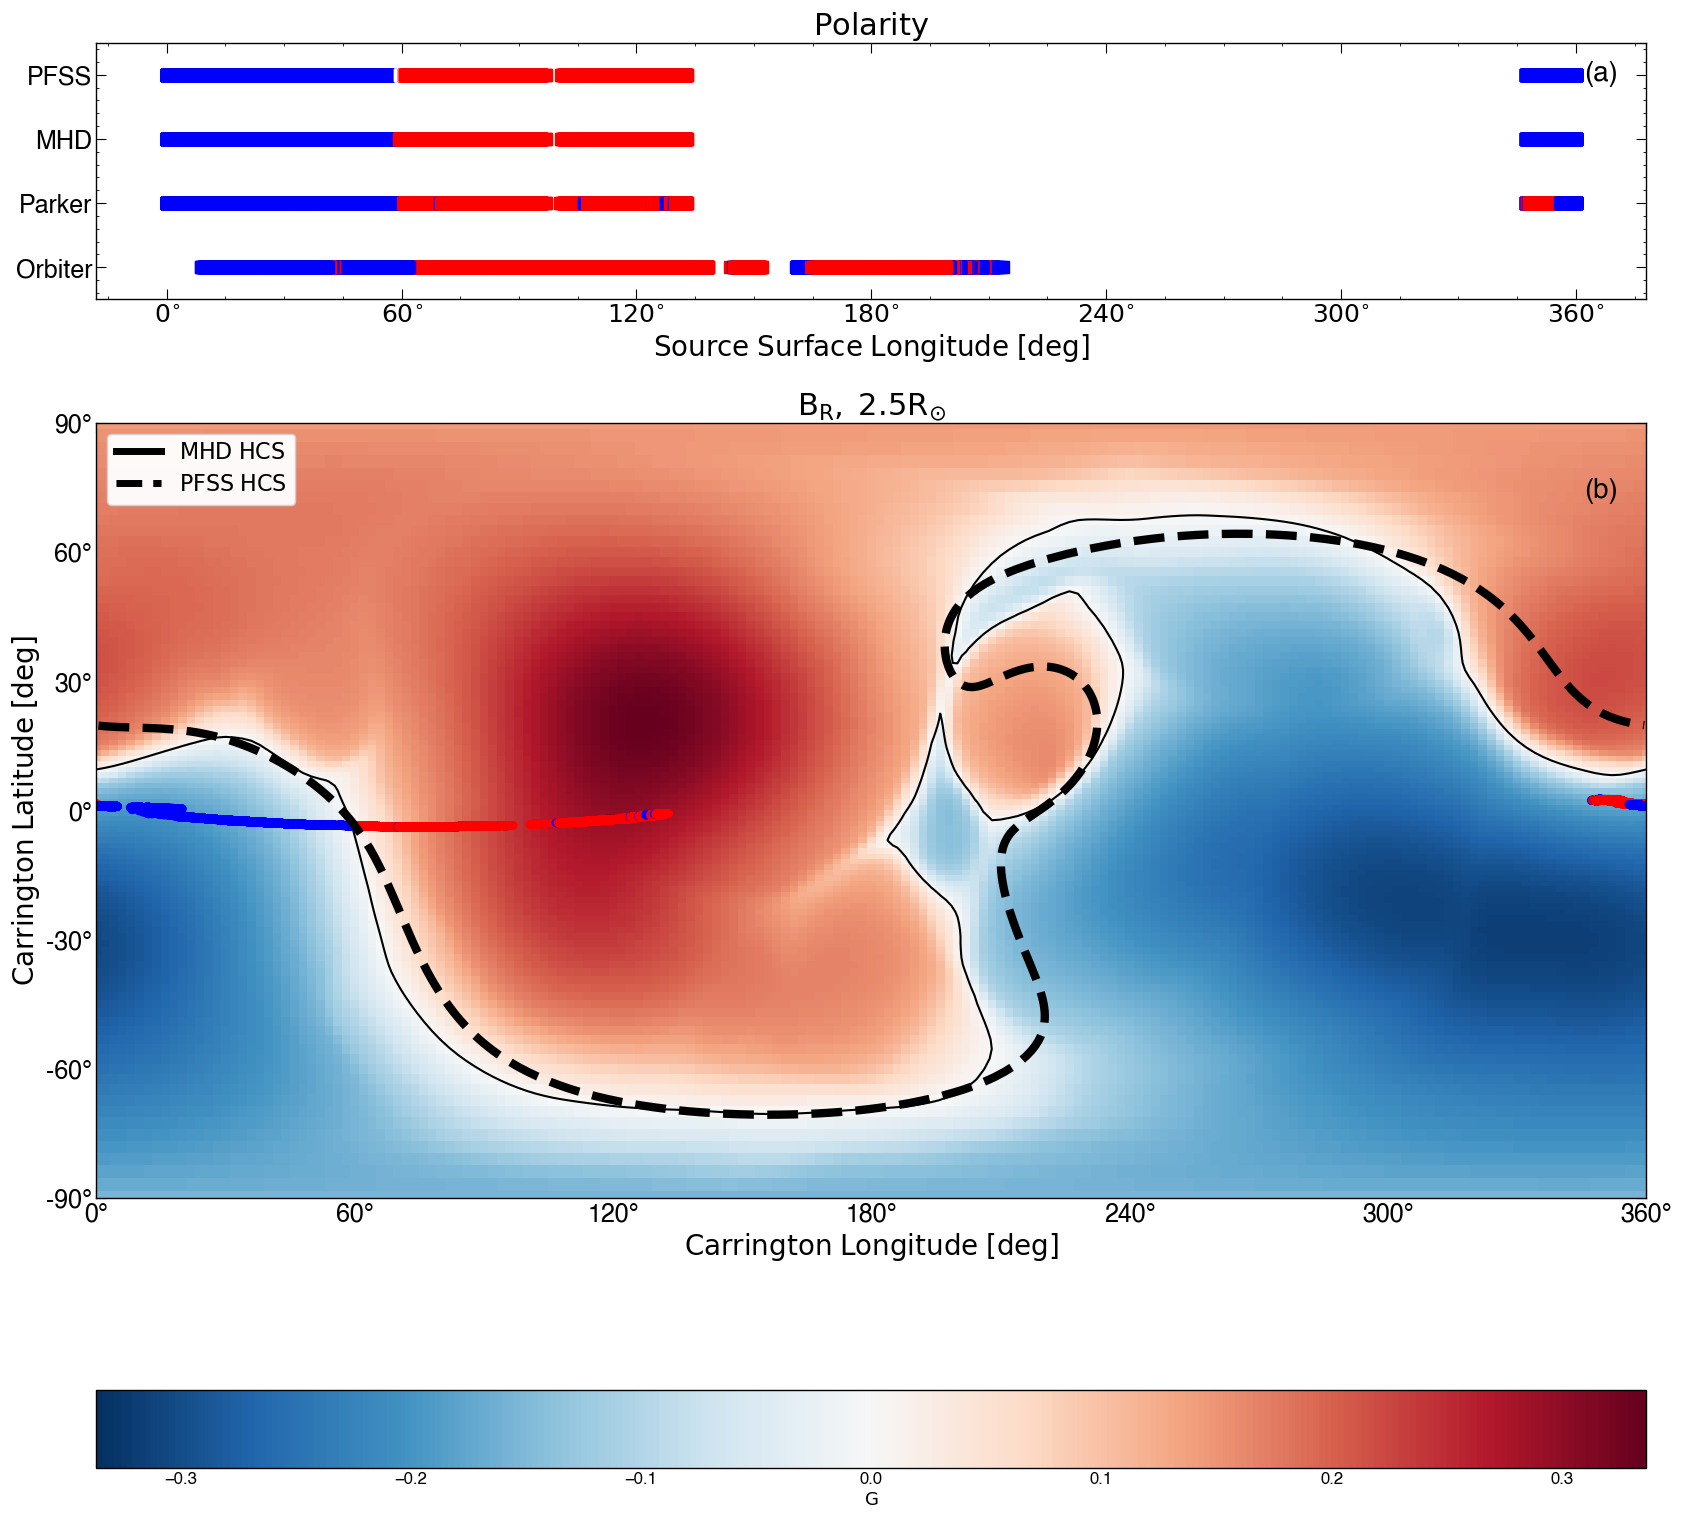

In [14]:
### CREATE FIGURE
import matplotlib.ticker as ticker
plot_style = os.path.join(PlotDir, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
plt.rcParams.update({'font.size': 20})
plt.style.use(plot_style)
fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(2, 1, height_ratios=[1, 5], hspace=0)

### ADD AXES
ax1 = fig.add_subplot(grid[0, :])
ax2 = fig.add_subplot(grid[1, :])

##### ---------- PANEL ONE: POLARITY COMPARISON  ---------- ######
ax = ax1
ss = 80

### PFSS RESULTS
ax1.scatter(psp_at_source_surface.lon, 2* np.ones(len(pfsspol)), c=pfsspol, cmap='bwr', marker='s', s=ss)

### MHD RESULTS
ax1.scatter(psp_at_source_surface.lon, np.ones(len(mhdpol)), c=mhdpol, cmap='bwr', marker='s', s=ss)

### PSP RESULTS
ax1.scatter(parker.sslon, np.zeros(len(ppol)), c=ppol, cmap='bwr', marker='s', s=ss)

### SOLAR ORBITER RESULTS
use = np.logical_and(orbiter.sslat<1, orbiter.sslat>-4)
ax1.scatter(orbiter.sslon, -1 * np.ones(len(spol)), c=spol, cmap='bwr', marker='s', s=ss)

### LABELS AND TITLES
ax.text(0.96, 0.93, '(a)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set(ylim=(-1.50, 2.5), yticks=(np.arange(-1.0, 2.1, step=1)), yticklabels=(['Orbiter', 'Parker', 'MHD', 'PFSS']))
ax.set(xticks=np.arange(0, 361, step=60), 
       xticklabels=['$0^{\circ}$', '$60^{\circ}$', '$120^{\circ}$', '$180^{\circ}$', '$240^{\circ}$', '$300^{\circ}$','$360^{\circ}$'])
ax.set_title(r'$\rm Polarity$', fontsize=22) 
ax.set_xlabel(r'$\rm Source \; Surface \; Longitude \; [deg]$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
# ax.set_ylabel()

##### ---------- PANEL TWO: HCS PFSS & MHD FIGURE  ---------- ######
ax=ax2

### MHD RESULTS
h_idx=-49
cbar_kwargs = {"orientation": "horizontal"}
corona_model['br'].plot_radial_cut(h_idx, ax=ax, cbar_kwargs=cbar_kwargs)
corona_model["br"].contour_radial_cut(h_idx, levels=[0], ax=ax, colors="k", zorder=1)
ax.set_title(r'$\rm B_R, \; 2.5 R_{\odot}$', fontsize=22)  # r'$\rm B_R, \; 2.51 R_{\odot}$'
ax.set_xlabel(r'$\rm Carrington \; Longitude \; [deg]$', fontsize=20)
ax.set_ylabel(r'$\rm Carrington \; Latitude \; [deg]$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.yaxis.set_minor_locator(ticker.NullLocator())

### MHD FOOTPOINTS -- still need tracer to work

### PARKER TRAJECTORY
ax.scatter(np.deg2rad(psp_at_source_surface.lon), np.deg2rad(psp_at_source_surface.lat), c=ppol, cmap='bwr', zorder=2, s=30)

### ORBITER TRAJECTORY
use = np.logical_and(orbiter.sslat<1, orbiter.sslat>-4)
ax.scatter(np.deg2rad(orbiter.sslon[use]*u.deg), np.deg2rad(orbiter.sslat[use]*u.deg), c=spol[use], cmap='bwr', zorder=2, s=10)

### PFSS HCS
ax.plot(np.deg2rad(hcs.lon), np.deg2rad(hcs.lat), color='k', zorder=5, linestyle='dashed', linewidth=6)

# ### PFSS FOOTPOINTS
# use = np.logical_and(psp_at_source_surface.lon.value >=0, psp_at_source_surface.lon.value <=180)
# nf=int(len(flines_psp)/400)
# lon_footpoints = flines_psp.open_field_lines.source_surface_feet.lon.value[::nf]
# lat_footpoints = flines_psp.open_field_lines.source_surface_feet.lat[::nf]
# use = np.logical_and(lon_footpoints >=0, lon_footpoints <=180)

# lon_footpoints = np.deg2rad(flines_psp.open_field_lines.solar_feet.lon[::nf])
# lat_footpoints = np.deg2rad(flines_psp.open_field_lines.solar_feet.lat[::nf])
# ax.scatter(lon_footpoints[use], lat_footpoints[use], s=15, color='grey', marker='s', zorder=6)
# ax.scatter(lon_footpoints[slow], lat_footpoints[slow], s=20, color=scol, marker='s', zorder=6)

### LEGEND 
# pfsshcs = mpatches.Patch(color='k', linestyle='--', label=r'$\rm PFSS \; HCS$')
# mhdhcs = mpatches.Patch(color='k',  label=r'$\rm MHD \; HCS$')
# pfssfp = mpatches.Patch(color='grey', label=r'$\rm PFSS \; Footpoints$')
# mhdfp = mpatches.Patch(color='orange', label=r'$\rm MHD \; Footpoints$')
# leg = ax.legend(handles=[pfsshcs, pfssfp, mhdhcs, mhdfp], loc='upper left', fontsize=16)
ax.text(0.96, 0.93, '(b)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

legend_elements = [
    mpl.lines.Line2D([0], [0], color='k', lw=5, label=r'$\rm MHD \; HCS$'),
    mpl.lines.Line2D([0], [0], color='black', lw=5, linestyle='--', label=r'$\rm PFSS \; HCS$')
    # mpatches.Patch(color='grey', label=r'$\rm PFSS \; Footpoints$')
# mhdfp = mpatches.Patch(color='orange', label=r'$\rm MHD \; Footpoints$')
]
leg = ax.legend(handles=legend_elements, loc='upper left', fontsize=16)
ax.add_artist(leg)

### SAVE FIGURE
plt.savefig(os.path.realpath('figures/fig9.png'), bbox_inches='tight')
plt.savefig(os.path.realpath('eps_figures/fig9.pdf'), bbox_inches='tight')


# Figure A.2: Comparison of MHD observables with observations

In [ ]:
### IDENTIFY PERIODS IN CARRINGTON COORDINATES
h = np.logical_and(parker.sslon > loc_hcs[0], parker.sslon < loc_hcs[1])
h1 = np.logical_and(parker.sslon > loc_hcs1[0], parker.sslon < loc_hcs1[1])
s = np.logical_and(parker.sslon > ssw[0], parker.sslon < ssw[1])
f = np.logical_and(parker.sslon > fsw[0], parker.sslon < fsw[1])
parker.lon[h1]


In [ ]:
# REGIONS
loc_hcs = [rollto180(parker.lon[h][0]*u.deg).value, rollto180(parker.lon[h][-1]*u.deg).value]
loc_hcs1 = [rollto180(parker.lon[h1][0]*u.deg).value, rollto180(parker.lon[h1][-1]*u.deg).value]
ssw =[rollto180(parker.lon[s][0]*u.deg).value, rollto180(parker.lon[s][-1]*u.deg).value]
fsw =[rollto180(parker.lon[f][0]*u.deg).value, rollto180(parker.lon[f][-1]*u.deg).value]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

### SETUP FIGURE
fig = plt.figure(figsize=(20, 10))
grid = plt.GridSpec(3, 1, height_ratios=[1, 1, 1], hspace=0)

### CREATE SUBPLOTS
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[1, 0])
ax3 = fig.add_subplot(grid[2, 0])


##### ---------- PANEL (A): RADIAL VELOCITY  ---------- ######
ax = ax1
ax.scatter(pl, parker.vr, c=parker.vr, cmap='inferno', s=3, label=r'$\rm Raw \; Data$')
ax.step(pdl, parkerdownl.vr, color='black', linewidth=3, label=r'$\rm Binned \; Data$')
ax.plot(pl, vr_sampled, color='red', linewidth=3, label=r'$\rm MHD \; Results$')
ax.set(ylim=(0, 1000), yticks=np.arange(100, 901, step=200))
ax.set_ylabel(ylabel=r'$\rm v_R \; [km \; s^{-1}]$', fontsize=20)
ax.set_xticklabels([])
ax.axhline(500, color='k', linestyle='dashed')

##### ---------- PANEL (B): PROTON DENSITY  ---------- ######
ax = ax2
ax.scatter(pl, parker.NpR2, c= parker.NpR2, cmap='spring', s=3)
ax.step(pdl, parkerdownl.NpR2, color='black', linewidth=3)
ax.plot(pl, rho_sampled*(1e-5), color='red', linewidth=3)
ax.set(ylim=(-7.5, 67.5), yticks=np.arange(0, 61, step=15))
ax.set_xticklabels([])
ax.set_ylabel(r'$\rm n_p R^2 \; [cm^{-3}]$', fontsize=20)

##### ---------- PANEL (C): RADIAL MAGNETIC FIELD  ---------- ######
ax = ax3
ax.scatter(pl, parker.BrR2, c=parker.BrR2, cmap='coolwarm', s=3)
ax.step(pdl, parkerdownl.BrR2, color='black', linewidth=3)
ax.plot(pl, br_sampled*2, color='red', linewidth=3)
ax.set(ylim=(-7.5, 7.5), yticks=np.arange(-6, 6.1, step=3))
ax.set_xlabel(xlabel=r'$\rm Carrington \; Longitude \; [deg]$', fontsize=20)
ax.set_ylabel(ylabel=r'$\rm B_R R^2 \; [nT]$', fontsize=20)
ax.axhline(0, color='k', linestyle='dashed')

# Shade regions
panel_labels=['(a)', '(b)', '(c)']
for i, ax in enumerate([ax1, ax2, ax3]):
    ### TICK PARAMS
    ax.tick_params(axis='both', which='major', labelsize=18) 

    ### ADD X-LIMITS
    ax.set(xlim=(-45, 135), xticks=np.arange(-30, 121, step=30))

    ### ADD THE GRID
    ax.grid(True, linestyle='--', linewidth=0.5)

    ### ADD REGIONS ###
    regions = [
        (loc_hcs[0], loc_hcs[1], hcol),
        (loc_hcs1[0], loc_hcs1[1], hcol),
        (ssw[0], ssw[1], scol),
        (fsw[0], fsw[1], fcol)
    ]

    lines = [
        loc_hcs[0],
        loc_hcs[1],
        loc_hcs1[0],
        loc_hcs1[1],
        ssw[0],
        ssw[1],
        fsw[0],
        fsw[1]
    ]

    ### PLOT LINES AND REGIONS ###
    for line in lines:
        ax.axvline(line, color='k', linestyle='dotted', zorder=5)

    for region in regions:
        ax.axvspan(region[0], region[1], color=region[2], zorder=-3)

    ### ADD PANEL LABELS
    ax.text(0.95, 0.93, panel_labels[i], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

### SET TITLE
# ax1.set_title(r'$\rm Parker \; Solar \; Probe$', fontsize=22)

### ADD LABELS FOR REGIONS
ax = ax1
ax.text(0.17, 0.96, r'$\rm HCS$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.text(0.21, 0.96, r'$\rm Sub-Alfv\'enic$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.text(0.475, 0.96, r'$\rm FSW$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.text(0.545, 0.96, r'$\rm HCS$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

### SAVE FIGURE
plt.savefig(os.path.realpath('figures/fig10.png'), bbox_inches='tight')
plt.savefig(os.path.realpath('eps_figures/fig10.eps'), bbox_inches='tight')
